In [9]:
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
DATA_DIRECTORY = "/Users/markusyoussef/Desktop/git/data"


RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"

### Functions

In [3]:
def normalized_laplacian(D):
    # can be optimized more
    diag = ((len(D)-1) - np.sum(D, axis=0)).reshape(-1,1)
    L  = D-1
    np.fill_diagonal(L, diag)
    L0 = np.multiply(np.multiply(diag**(-1/2),L).T,diag**(-1/2))
    return L0


# def p_value(n_GO_terms, 
#             n_cluster, 
#             list_of_success_states,
#             list_of_draws,
#             list_of_observed_successes):
#     
#     success_states = list_of_success_states[n_GO_terms]
#     draws = list_of_draws[n_cluster]
#     observed_successes = list_of_observed_successes[n_GO_terms][n_clusters]
# 
#     K = len(success_states)
#     n = len(draws)
#     k = len(observed_successes)
#     
#     return 1-hypergeom.cdf(k-1, N, n, K)

### Cluster independent variables

In [4]:
annotation_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_BP_sc.csv")
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
D = np.genfromtxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd0.txt")

GO_population = set(annotation_df.GO_ID)
PPI_population = set(PPI_nx.nodes())

### Name-to-Integer dictionaries

In [5]:
int2gene = dict(enumerate(PPI_population))
gene2int = dict(zip(int2gene.values(), int2gene.keys()))

int2GO = dict(enumerate(GO_population))
GO2int = dict(zip(int2GO.values(), int2GO.keys()))

### Preparation

Let $N$ be the number of genes in the PPI.   
Each GO-term defines a 'state' in which $K$ proteins are annotated with this term; these are seen a _successes_.    
A given cluster defines an 'experiment', in which the number of draws, $n$, corresponds to the length of the cluster.    
The number of _successful draws_ $k$ corresponds to the number of annotated genes in the given cluster.

In [6]:
# Number of drawable elements is fixed throughout the whole analysis
N = len(PPI_population)

list_of_success_states = [set(map(gene2int.get, annotation_df.Systematic_ID[annotation_df.GO_ID == go_id]))
                              for go_id in GO_population]

# This will be our K, see below
array_of_total_successes = np.array(list(map(len,list_of_success_states))).reshape(-1,1)

### Here we GO

In [15]:
MAX_CLUSTERS = 5
alpha = [0.001, 0.01, 0.05]

In [16]:
tvd0_high_coverage = []
tvd0_middle_coverage = []
tvd0_low_coverage = []

t1 = time.time()

for n_clusters in range(2, MAX_CLUSTERS):
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec')
    
    # Perform clustering
    initial_medoids = random.sample(range(N), n_clusters)
    kmedoids_instance = kmedoids(1-D, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    
    list_of_experiments = [set(cluster) for cluster in clusters]
    
    # For each GO term and cluster we get an experiment 
    array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                        for success_states in list_of_success_states])
    
    
    N = N                            # defined in section 'Preparation'
    K = array_of_total_successes     # defined in section 'Preparation'
    n = list(map(len, clusters))     # cluster length
    k = array_of_observed_successes 
    
    # scipy has a really messed up nomeclature... 
    p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
    p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
    
    m = p_values_array.size
    
    hc_enrichment_df = p_values_df < alpha[0]/m
    mc_enrichment_df = p_values_df < alpha[1]/m
    lc_enrichment_df = p_values_df < alpha[2]/m
    
    tvd0_high_coverage.append(  sum(hc_enrichment_df.any())/n_clusters)
    tvd0_middle_coverage.append(sum(mc_enrichment_df.any())/n_clusters)
    tvd0_low_coverage.append(   sum(lc_enrichment_df.any())/n_clusters)

2: 0.00sec


KeyboardInterrupt: 

In [ ]:
tvd='0'

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.plot(range(2,MAX_CLUSTERS), eval(f"tvd{tvd}_middle_coverage"), 
         label=r'$TVD_{123}$', 
         linewidth=2.5);
plt.fill_between(range(2,MAX_CLUSTERS), 
                 eval(f"tvd{tvd}_high_coverage"), 
                 eval(f"tvd{tvd}_low_coverage"), 
                 alpha=0.1);


#plt.plot(range(2,MAX_CLUSTER), tijana_spectral_middle_coverage, 
#         label=r'Tijana',
#         linewidth=2.5);
#plt.fill_between(range(2,MAX_CLUSTER), tijana_spectral_high_coverage, tijana_spectral_low_coverage, alpha=0.1);


ax.set_xlabel('# clusters', fontsize=32)
ax.set_ylabel('% enriched', fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
#fig.savefig(f"data/plots/tvd_{tvd}.png")

In [111]:
k.size

9316

In [106]:
1-hypergeom.cdf(k=k-1, M=N, N=list(map(len, clusters)), n=K)

array([[0.33339506, 0.8128368 ],
       [0.61143458, 0.75665344],
       [0.47888955, 0.55283378],
       ...,
       [0.9918345 , 0.06204634],
       [0.83500817, 0.57260943],
       [1.        , 0.30086436]])

In [108]:
1- hypergeom.cdf(k-1, M=N, N=3141, n=K)

array([[0.66660494, 0.8128368 ],
       [0.75665344, 0.75665344],
       [0.99999999, 0.55283378],
       ...,
       [0.9982849 , 0.06204634],
       [0.90805015, 0.57260943],
       [1.        , 0.30086436]])

In [95]:
N    = N                                    # defined in section 'Preparation'
K    = array_of_total_successes             # defined in section 'Preparation'
_, n = array_of_observed_successes.shape    # #rows = #GO-terms
k    = array_of_observed_successes 

In [100]:
len(clusters[0])

2585

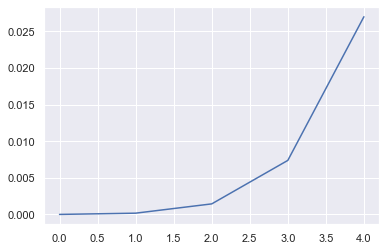

In [101]:
fig, ax = plt.subplots()
ax.plot(range(5), hypergeom.cdf(range(5), M=N, n=19, N=2585))#
#ax.set_ylim(0,1);

In [87]:
hypergeom.cdf(range(5), M=2, N=19, n=5726)

array([nan, nan, nan, nan, nan])

In [67]:
scipy.__version__

'1.3.1'

# Test

In [9]:
# Perform clustering
initial_medoids = [1, 500]
kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()

list_of_experiments = [set(cluster) for cluster in clusters]

# For each GO term and cluster we get an experiment 
array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                    for success_states in list_of_success_states])

In [28]:
_, n = array_of_observed_successes.shape
K = np.array(list(map(len,list_of_success_states)))

In [29]:
array_of_observed_successes

array([[36, 42],
       [ 0,  3],
       [ 1,  0],
       ...,
       [ 2,  3],
       [ 1,  0],
       [ 8,  7]])

In [38]:
test = 1-hypergeom.cdf(array_of_observed_successes-1, N, n, K.reshape(-1,1))

In [39]:
test.shape

(4658, 2)

In [41]:
array_of_observed_successes.sum(axis=1)

array([78,  3,  1, ...,  5,  1, 15])

In [8]:
import random
import string

def randomString(stringLength=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

In [ ]:
my_map = { i: randomString(10) for i in range(100)}

In [10]:
%%timeit
dict(map(reversed, my_map.items()))

39.5 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%%timeit
{v: k for k, v in my_map.items()}

10.7 µs ± 331 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
%%timeit
dict(zip(my_map.values(), my_map.keys()))

7.91 µs ± 69.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
